In [1]:
# for use with collab:
#from google.colab import drive
#drive.mount('/content/drive')
#!git clone --depth 1 -b rewrite https://github.com/juszjusz/coordinating-quantifiers
#%cd coordinating-quantifiers/v2

In [11]:
import importlib
import plot_utils
import domain_objects
import calculator

importlib.reload(plot_utils)
importlib.reload(domain_objects)
importlib.reload(calculator)

<module 'calculator' from 'C:\\Users\\juszynski\\Desktop\\wspace\\coordinating-quantifiers\\v2\\calculator.py'>

## Simulation Control Panel

In [13]:
import numpy as np
from domain_objects import GameParams, NewAgent
from new_guessing_game import run_simulation, run_simulations_in_parallel, recreate_agents_snapshots_in_parallel, select_speaker, select_hearer, avg_series, random_functions
from calculator import NumericCalculator, QuotientCalculator, load_stimuli_and_calculator
from ipywidgets import widgets, HBox, VBox
from IPython.display import display, clear_output

style = {'description_width': 'initial'}

stimuli_selection_widget = widgets.Select(options=['numeric', 'quotient'], value='quotient',
                                          description='Stimuli Type:', disabled=False)

ans_selection_widget = widgets.Checkbox(value=True, description='with ANS')

runs_selection_widget = widgets.IntSlider(
    value=2,
    min=1,
    max=10,
    step=1,
    description='Number of runs',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)

population_size_selection_widget = widgets.IntSlider(
    value=10,
    min=2,
    max=20,
    step=2,
    description='Population size',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)

steps_selection_widget = widgets.IntSlider(
    value=3000,
    min=100,
    max=5000,
    step=100,
    description='Number of steps',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)

run_simulation_button = widgets.Button(
    description='Run Simulation',
    disabled=False,
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    icon='play'
)

simulation_result = {}
output = widgets.Output()

def run_simulation_action(obj):
    run_simulation_button.disabled = True
    run_simulation_button.button_style = 'warning'
    run_simulation_button.icon = 'hourglass'
    run_simulation_button.description = 'Running ...'

    runs_selection_widget.disabled = True
    population_size_selection_widget.disabled = True
    ans_selection_widget.disabled = True
    steps_selection_widget.disabled = True
    stimuli_selection_widget.disabled = True

    runs = runs_selection_widget.value
    population_size = population_size_selection_widget.value
    stimulus = stimuli_selection_widget.value
    steps = steps_selection_widget.value
    with_ans = ans_selection_widget.value

    max_num = 100
    discriminative_threshold = 0.95
    discriminative_history_length = 50
    delta_inc = 0.2
    delta_dec = 0.2
    delta_inh = 0.2
    alpha = 0.01
    super_alpha = 0.001
    beta = 0.2
    guessing_game_2 = False
    seed = 100

    params = GameParams(population_size=population_size,
                        stimulus=stimulus,
                        max_num=max_num,
                        discriminative_threshold=discriminative_threshold,
                        discriminative_history_length=discriminative_threshold,
                        delta_inc=delta_inc,
                        delta_dec=delta_dec,
                        delta_inh=delta_inh,
                        alpha=alpha,
                        super_alpha=super_alpha,
                        beta=beta,
                        steps=steps,
                        runs=runs,
                        guessing_game_2=guessing_game_2,
                        seed=seed)

    with output:
        clear_output()
        print('Running simulation with params:', vars(params))

        stimuli, calculator = load_stimuli_and_calculator(params.stimulus)

        populations = run_simulations_in_parallel(stimuli, calculator, params)

        run_simulation_button.button_style = 'success'
        run_simulation_button.disabled = False
        run_simulation_button.icon = 'play'
        run_simulation_button.description = 'Run Simulation'

        runs_selection_widget.disabled = False
        population_size_selection_widget.disabled = False
        ans_selection_widget.disabled = False
        steps_selection_widget.disabled = False
        stimuli_selection_widget.disabled = False
        
        simulation_result['stimuli'] = stimuli
        simulation_result['params'] = params
        simulation_result['populations'] = populations
        simulation_result['calculator'] = calculator


run_simulation_button.on_click(run_simulation_action)
control_pane = HBox(
    [stimuli_selection_widget, ans_selection_widget, VBox([runs_selection_widget, population_size_selection_widget, steps_selection_widget])])

display(VBox([run_simulation_button, widgets.HTML(value="<hr/>"), control_pane]), output)

Output()

In [14]:
populations = simulation_result['populations']
stimuli = simulation_result['stimuli']
calculator = simulation_result['calculator']
params = simulation_result['params']

windowed_communicative_success1 = np.array([[avg_series(a.get_communicative_success1()) for a in population] for population in populations]) * 100
windowed_discriminative_success = np.array([[avg_series(a.get_discriminative_success()) for a in population] for population in populations]) * 100

averaged_windowed_communicative_success1 = np.mean(windowed_communicative_success1, axis=1)
averaged_windowed_discriminative_success= np.mean(windowed_discriminative_success, axis=1)

# Analysis & Visualizations

## Single Agent Analysis

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from plot_utils import bokeh_plot_category, plot_category
import stats
from stats import new_confidence_intervals


In [20]:
agent = populations[0][0]
meanings = agent.compute_word_meanings()

word, activations = list(meanings.items())[4]
stimuli_meaning = np.array(stimuli)[activations]
most_connected_category = agent.get_most_connected_category(word)
most_connected_category_pdf = most_connected_category.discretized_distribution(calculator)

stimuli_meaning = [float(v) for v in stimuli_meaning]
figure = plot_utils.bokeh_plot_category(most_connected_category, calculator.domain(), most_connected_category_pdf,
                                        stimuli_meaning)

output_notebook()
show(figure)

Loading BokehJS ...

In [21]:
agent = populations[0][0]
word2pragmatic_meaning = agent.compute_word_pragmatic_meanings(stimuli)

word, pragmatic_meaning = list(meanings.items())[0]

most_connected_category = agent.get_most_connected_category(word)
most_connected_category_pdf = most_connected_category.discretized_distribution(calculator)

stimuli_meaning = [float(v) for v in pragmatic_meaning]
figure = plot_utils.bokeh_plot_category(most_connected_category, calculator.domain(), most_connected_category_pdf,
                                        stimuli_meaning)

output_notebook()
show(figure)

Loading BokehJS ...

recreating agent 6 by updates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 4936.93it/s]


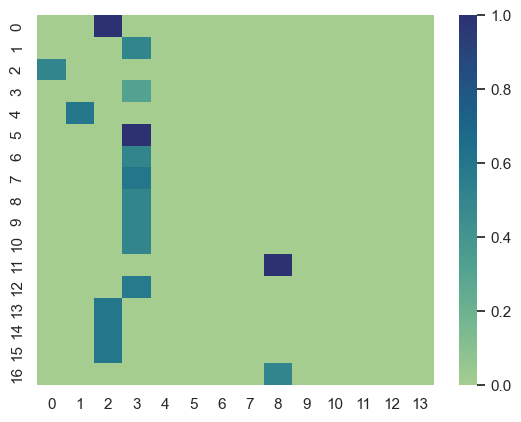

In [22]:
agent_snapshots= NewAgent.recreate_from_history(agent_id=agent.agent_id, calculator=calculator, game_params=params, updates_history=agent.updates_history)

step, snapshot = agent_snapshots[1]
agent_dict = NewAgent.to_dict(snapshot)
lxc = np.array(agent_dict['lxc'])

sns.set()
ax = sns.heatmap(lxc, vmin=0, vmax=1, cmap="crest")
plt.show()

## Population Level Statistics

In [ ]:
populations_snapshots = recreate_agents_snapshots_in_parallel(populations=populations, stimuli=stimuli, calculator=calculator, game_params=params)

flatten_population_snapshots = [agent_snapshots for population in populations_snapshots for agent_snapshots in population]

snapshot_steps = [step for step, _, _, _, _ in flatten_population_snapshots[0]]

In [36]:
active_lexicon_snapshots = [[len(active_lexicon) for _, _, active_lexicon, _, _ in agent_snapshots] for agent_snapshots in flatten_population_snapshots]

averaged_active_lexicon_by_agent = np.mean(active_lexicon_snapshots, axis=0)

active_lexicon_lower, active_lexicon_upper = new_confidence_intervals(np.array(active_lexicon_snapshots))

In [37]:
from bokeh.plotting import figure
from bokeh.models import LinearAxis, Range1d, Band, ColumnDataSource

fig = figure(title=f'Success Rate for {params.stimulus} stimuli', x_axis_label='Steps', width=750)

fig.extra_y_ranges = {'active_lexicon_range': Range1d(start=0, end=max(averaged_active_lexicon_by_agent)*1.5)}
fig.add_layout(LinearAxis(y_range_name="active_lexicon_range"), 'right')

source = ColumnDataSource(data=dict(x=snapshot_steps, y=averaged_active_lexicon_by_agent, y_lower=active_lexicon_lower, y_upper=active_lexicon_upper))

# https://docs.bokeh.org/en/1.0.4/docs/user_guide/examples/plotting_band.html doesnt work :(
band = Band(base='x', lower='lower', upper='upper', source=source, level='underlay', fill_alpha=1.0, line_width=1, line_color='black')

steps_range = [*range(params.steps)]
for ds in averaged_windowed_discriminative_success:
    fig.line(steps_range, ds, legend_label='discriminative success', line_width=.1, color='red')
for cs1 in averaged_windowed_communicative_success1:
    fig.line(steps_range, cs1, legend_label='communicative success 1', line_width=.1, color='green')

fig.line(steps_range, np.mean(averaged_windowed_discriminative_success, axis=0), legend_label='discriminative success', line_width=.5, color='red')
fig.line(steps_range, np.mean(averaged_windowed_communicative_success1, axis=0), legend_label='communicative success 1', line_width=.5, color='green')
fig.line(snapshot_steps, averaged_active_lexicon_by_agent, legend_label='|active lexicon|', y_range_name='active_lexicon_range', line_width=.5, color='blue')
fig.line(snapshot_steps, active_lexicon_upper, legend_label='|active lexicon|', y_range_name='active_lexicon_range', line_width=.1, color='blue')
fig.line(snapshot_steps, active_lexicon_lower, legend_label='|active lexicon|', y_range_name='active_lexicon_range', line_width=.1, color='blue')

fig.add_layout(band)

fig.legend.location = 'bottom_right'

output_notebook()
show(fig)

Loading BokehJS ...

In [ ]:
monotonicity_snapshots = [[[monotonicity for _, _, _, monotonicity, _ in agent_snapshots] for agent_snapshots in population_snapshots] for population_snapshots in populations_snapshots]
convexity_snapshots = [[[convexity for _, _, _, _, convexity in agent_snapshots] for agent_snapshots in population_snapshots] for population_snapshots in populations_snapshots]

averaged_monotonicity_populations_snapshots = np.mean(monotonicity_snapshots, axis=1) * 100
averaged_monotonicity_snapshots = np.mean(averaged_monotonicity_populations_snapshots, axis=0)

averaged_convexity_populations_snapshots = np.mean(convexity_snapshots, axis=1) * 100
averaged_convexity_snapshots = np.mean(averaged_convexity_populations_snapshots, axis=0)

In [56]:
from bokeh.plotting import figure
from bokeh.models import LinearAxis, Range1d, Band, ColumnDataSource

fig = figure(title=f'Monotonicity/Convexity Rate for {params.stimulus} stimuli', x_axis_label='Steps', y_range=(0,100), width=750)

for monotonicity in averaged_monotonicity_populations_snapshots:
    fig.line(snapshot_steps, monotonicity, legend_label='Monotonicity', line_width=.1, color='magenta')
    
fig.line(snapshot_steps, averaged_monotonicity_snapshots, legend_label='Monotonicity', line_width=.5, color='magenta')

for convexity in averaged_convexity_populations_snapshots:
    fig.line(snapshot_steps, convexity, legend_label='Convexity', line_width=.1, color='cyan')

fig.line(snapshot_steps, averaged_convexity_snapshots, legend_label='Convexity', line_width=.5, color='cyan')

fig.legend.location = 'bottom_right'

output_notebook()
show(fig)

Loading BokehJS ...